In [0]:
#partially used as example
#https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8
#https://www.pyimagesearch.com/2020/03/30/autoencoders-for-content-based-image-retrieval-with-keras-and-tensorflow/

!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:25<00:00, 45.6MB/s]
100% 1.33G/1.33G [00:25<00:00, 56.1MB/s]


In [0]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'
Z_DIM = 512 #dimension of encoder vector, took it from model summary

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

In [0]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
import cv2

In [0]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
INPUT_DIM = (256, 256, 3)
BATCH_SIZE = 32

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(
    DATA_FOLDER,
    target_size=INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode='input',
    subset='training'
)

Found 202599 images belonging to 1 classes.


In [0]:
#ENCODER
from keras.applications import ResNet50
def build_encoder(input_dim, output_dim):
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_dim)
  # for layer in base_model.layers:
  #   layer.trainable = False
  encoder_input = Input(shape=input_dim, name='encoder_input')
  x = base_model(encoder_input)
  x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(x)
  #x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(x)
  encoder_output = Flatten()(x)
  global VECTOR_SIZE
  VECTOR_SIZE = K.int_shape(encoder_output)[1:]
  return VECTOR_SIZE, encoder_input, encoder_output, Model(encoder_input, encoder_output)

VECTOR_SIZE, encoder_input, encoder_output, encoder = build_encoder(input_dim=INPUT_DIM, output_dim=Z_DIM)
print(encoder.summary())
print(VECTOR_SIZE)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         4718848   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
Total params: 28,306,560
Trainable params: 28,253,440
Non-trainable params: 53,120
_________________________________________________________________
None
(4096,)


In [0]:
#this part is made just for test, to see from what size to start decoding
#to be able to achieve initial image size
#in this case needed number is shape_before_flattening
def check_size(input_dim, conv_filters, conv_kernel_size, conv_strides):
  n_layers = len(conv_filters)

  encoder_input = Input(shape=input_dim)
  x = encoder_input

  for i in range(n_layers):
    x = Conv2D(filters = conv_filters[i],
               kernel_size = conv_kernel_size[i],
               strides = conv_strides[i],
               padding='same')(x)
  global shape_before_flattening
  shape_before_flattening = K.int_shape(x)[1:]
  x = Flatten()(x)
  return shape_before_flattening, Model(encoder_input, x)

shape_before_flattening, model = check_size(INPUT_DIM, [32,64,64,64], [3,3,3,3], [2,2,2,2])
model.summary()
print(shape_before_flattening)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
_______________________________________________________

In [0]:
#DECODER
def build_decoder(input_dim, shape_before, conv_filters,
                  conv_kernel_size, conv_strides):
  n_layers = len(conv_filters)

  decoder_input = Input(shape=input_dim, name='decoder_input')

  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  for i in range(n_layers):
    x = Conv2DTranspose(filters=conv_filters[i],
                        kernel_size=conv_kernel_size[i],
                        strides=conv_strides[i],
                        padding='same')(x)
  
    if i < n_layers - 1:
      x = LeakyReLU()(x)
    else:
      decoder_output = Activation('sigmoid')(x)
    
  
  return decoder_input, decoder_output, Model(decoder_input, x)

decoder_input, decoder_output, decoder = build_decoder(input_dim=VECTOR_SIZE,
                        shape_before = shape_before_flattening,
                        conv_filters=[64,64,32,3],
                        conv_kernel_size=[3,3,3,3],
                        conv_strides=[2,2,2,2])
decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             67125248  
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0   

In [0]:
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder_output)
autoencoder = Model(autoencoder_input, autoencoder_output)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         4718848   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
model_3 (Model)              (None, 256, 256, 3)       67218435  
Total params: 95,524,995
Trainable params: 95,471,875
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
#Compilation and Training
LEARNING_RATE = 0.0005
N_EPOCHS = 1
optimizer = Adam(lr=LEARNING_RATE)

def r_loss(y_true, y_pred):
  return K.mean(K.square(y_true-y_pred), axis=[1,2,3])

autoencoder.compile(optimizer=optimizer,loss=r_loss)

checkpoint = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER,'AE/weights.h5'), 
                             save_weights_only=True, verbose=1)

history = autoencoder.fit_generator(data_flow,
                          shuffle=True,
                          epochs=N_EPOCHS,
                          initial_epoch=0,
                          steps_per_epoch=NUM_IMAGES/BATCH_SIZE,
                          callbacks=[checkpoint])


Epoch 1/1
6332/6331 [==============================] - 11126s 2s/step - loss: 0.0074

Epoch 00001: saving model to ./weights/AE/weights.h5


In [0]:
autoencoder.load_weights('/content/drive/My Drive/Deep Learning Stuff/img_search_1_working_weights.h5')
print("Loaded model from disk")

Loaded model from disk


['img_align_celeba/000001.jpg', 'img_align_celeba/000002.jpg', 'img_align_celeba/000003.jpg', 'img_align_celeba/000004.jpg', 'img_align_celeba/000005.jpg', 'img_align_celeba/000006.jpg', 'img_align_celeba/000007.jpg', 'img_align_celeba/000008.jpg', 'img_align_celeba/000009.jpg', 'img_align_celeba/000010.jpg', 'img_align_celeba/000011.jpg', 'img_align_celeba/000012.jpg', 'img_align_celeba/000013.jpg', 'img_align_celeba/000014.jpg', 'img_align_celeba/000015.jpg', 'img_align_celeba/000016.jpg', 'img_align_celeba/000017.jpg', 'img_align_celeba/000018.jpg', 'img_align_celeba/000019.jpg', 'img_align_celeba/000020.jpg', 'img_align_celeba/000021.jpg', 'img_align_celeba/000022.jpg', 'img_align_celeba/000023.jpg', 'img_align_celeba/000024.jpg', 'img_align_celeba/000025.jpg', 'img_align_celeba/000026.jpg', 'img_align_celeba/000027.jpg', 'img_align_celeba/000028.jpg', 'img_align_celeba/000029.jpg', 'img_align_celeba/000030.jpg', 'img_align_celeba/000031.jpg', 'img_align_celeba/000032.jpg']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


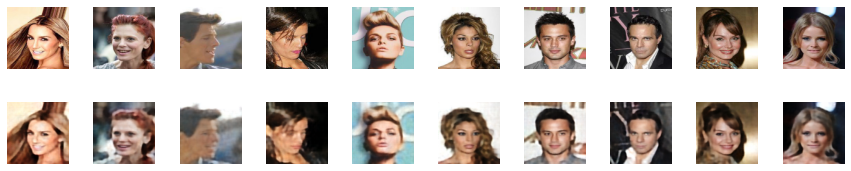

In [0]:
#VISUAL TEST
#model works perfectly
#first row are original images
#second row are reconstructed images through decoder
import matplotlib.pyplot as plt

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

#get names of generated images
idx = (data_flow.batch_index-1)*data_flow.batch_size
print(data_flow.filenames[idx:idx+data_flow.batch_size])

def plot_compare(images=None, add_noise=False):
  n_to_show = images.shape[0]
  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size=(n_to_show, 200))
    reconst_images = decoder.predict(encodings)
  else:
    reconst_images = autoencoder.predict(images)
  print(images.shape)

  fig = plt.figure(figsize=(15,3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
    img = images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.imshow(img)

  for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

plot_compare(example_images)

In [0]:
set_to_visualize_results = 0#will be used for test
#START MAKING THE SEARCH
import pickle
#create N features of images
def create_index(data_flow, index_size):
  features = []
  names = []
  for i in range(index_size//BATCH_SIZE):
    image_set = next(data_flow)
    if i==0:
      global set_to_visualize_results
      set_to_visualize_results = image_set
    #get names of generated images
    idx = (data_flow.batch_index-1)*data_flow.batch_size
    nms = data_flow.filenames[idx:idx+data_flow.batch_size]

    #first or last batch wont return names
    if len(nms)==0:
      continue

    for j in nms:
      names.append(j)

    vectors = encoder.predict(image_set[0])
    for j in vectors:
      features.append(j)

    if len(nms)!=len(vectors):
      print('something went wrong')

  data = {"features": features, "names":names}
  #print("[INFO] saving index...")
  #f = open('index.pickle', 'wb')
  #f.write(pickle.dumps(data))
  #f.close()

  return data

data = create_index(data_flow, 500)

In [0]:
def euclidean(a,b):
  # compute and return the euclidean distance between two vectors
  return np.linalg.norm(a-b)

def perform_search(queryFeatures, index, maxResults=20):
  results = []

  for i in range(len(index['features'])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
    d = euclidean(queryFeatures, index["features"][i])
    results.append((d,index["names"][i]))
  
  results = sorted(results)
  results = results[:maxResults]

  return results

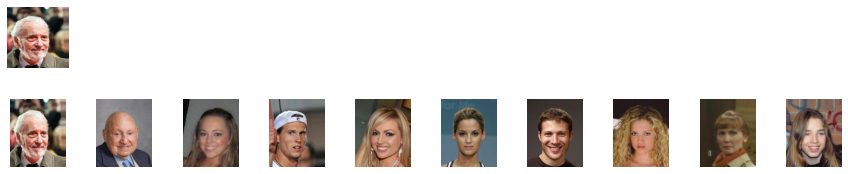

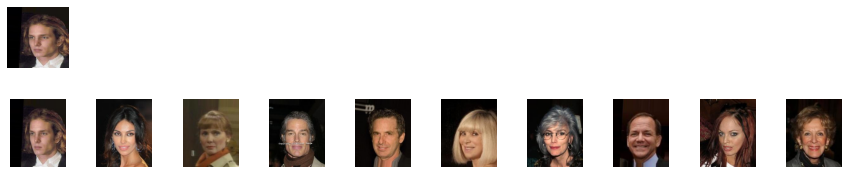

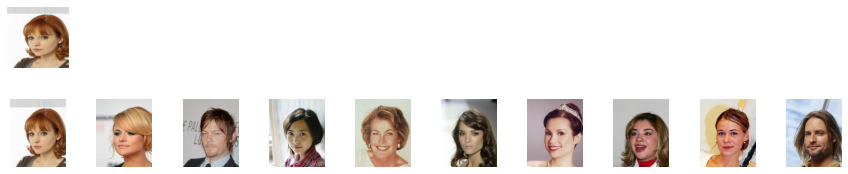

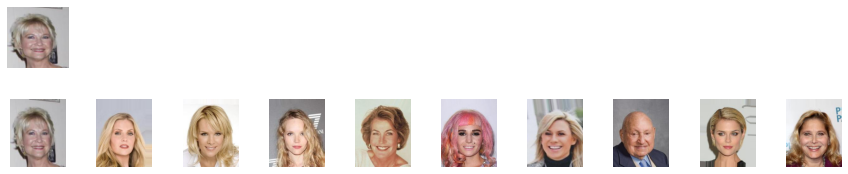

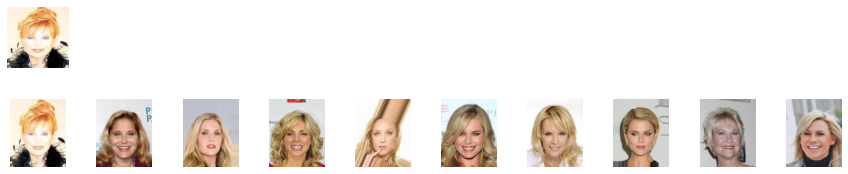

In [0]:
from google.colab.patches import cv2_imshow
example_batch = set_to_visualize_results[0]
example_images = example_batch[:5]
for k in example_images:
  #first image is the query
  #row of images below are 10 similar to it
  img_to_show = k
  img = np.expand_dims(img_to_show, axis=0)
  query = encoder.predict(img)
  
  res = perform_search(query, data, 10)

  n_to_show = len(res)
  fig = plt.figure(figsize=(15,3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.imshow(img_to_show)
    break

  for i,v in enumerate(res):
    img = cv2.imread('/content/data/img_align_celeba/'+v[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

In [0]:
#TESTING HOW IT WORKS ON YOUR FASHION DATASET

#data from my drive
!cp "/content/drive/My Drive/Deep Learning Stuff/images.zip" .
!unzip images.zip

Archive:  images.zip
replace images/train/1/d4981df41e40a34382de4f76d798ba6f32ba78f980ede537fd7bb213aa98be06.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
fashion_data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/images/train',
    target_size=INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode='input',
    subset='training'
)

Found 2064 images belonging to 1 classes.


In [0]:
fashion_data = create_index(fashion_data_flow, 2000)

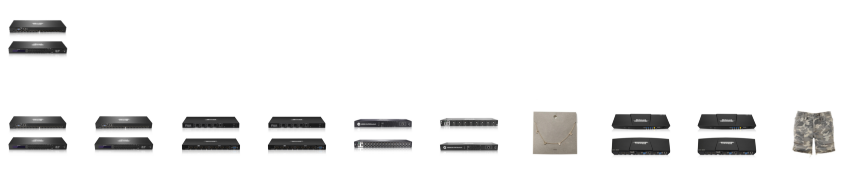

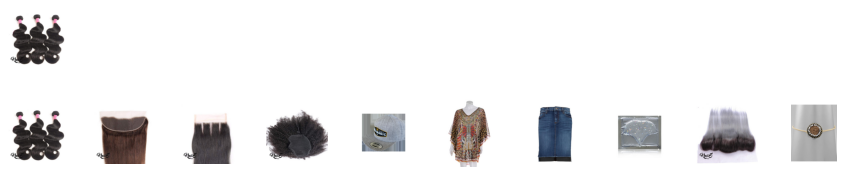

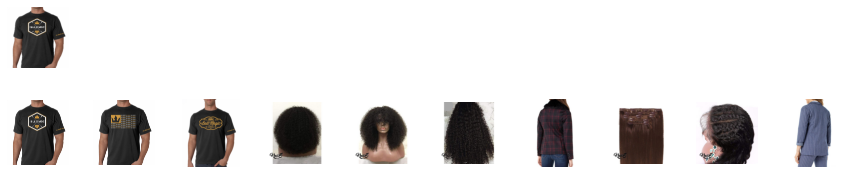

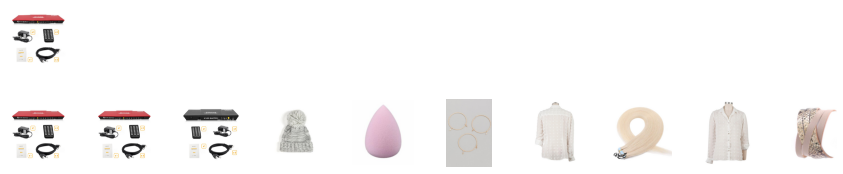

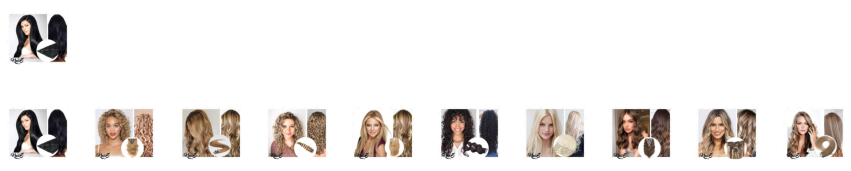

In [0]:
example_batch = set_to_visualize_results[0]
example_images = example_batch[:5]
for k in example_images:
  #first image is the query
  #row of images below are 10 similar to it
  img_to_show = k
  img = np.expand_dims(img_to_show, axis=0)
  query = encoder.predict(img)
  
  res = perform_search(query, fashion_data, 10)

  n_to_show = len(res)
  fig = plt.figure(figsize=(15,3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.imshow(img_to_show)
    break

  for i,v in enumerate(res):
    img = cv2.imread('/content/images/train/'+v[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)